In [1]:
seed = 100

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec as gs 
from matplotlib.patches import Patch
import matplotlib as mpl
from cycler import cycler
import geopandas as gpd

In [3]:
from sklearn.preprocessing import StandardScaler
import umap, umap.plot, os
from sklearn.cluster import KMeans

In [4]:
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from lightgbm import LGBMClassifier
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE, KMeansSMOTE
from sklearn.linear_model import LogisticRegression

In [5]:
import shap
from pprint import pprint

In [6]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.sans-serif": 'computer modern roman'})

<br>

# Code

## Cluster

In [7]:
def getSheet(name):
    df = pd.read_excel("rci.xls", sheetto_latex=name, header=[0, 1, 2, 3], index_col=[0,1,2,3])
    df.index = df.index.get_level_values(1)
    df.columns = df.columns.get_level_values('indicator')#+"__"+ df.columns.get_level_values('reference year').astype(str)).str.replace(' ','_').str.lower()
    return df

In [8]:
def getEmbed(df, filename, n_):
    loc = f'data/{filename}/embed_{n_}.csv'
    if loc.split("/")[-1] not in os.listdir("/".join(loc.split("/")[:-1])): 
        reducer = umap.UMAP(n_neighbors=30,min_dist=0.0,
                            n_components=n_,random_state=42,)
        scaled = StandardScaler().fit_transform(df)
        embedding = reducer.fit_transform(scaled)
        np.savetxt(loc, embedding, delimiter=",")
    else: embedding = np.genfromtxt(loc, delimiter=',')
    return embedding

In [9]:
def appendEurostat(df_in, ks): df = df_in.copy(); df['k'] = ks; return df

In [10]:
def addEuro(geodf, dic): df = geodf[geodf.NUTS_ID.isin(dic.keys())].copy(); df['metric'] = df.NUTS_ID.map(dic); return df

In [175]:
def plotClusterEU(name, df, series_clusters, ncluster, title, color):

    mosaic = '''
    ACC
    BCC
    '''
    color_list = [plt.cm.Pastel2_r(x) for x in range(ncluster)]
    color_map = mpl.colors.ListedColormap(color_list)
    
    geodf = gpd.read_file("/home/boturon/proj/geo/NUTS_RG_60M_2021_3035.shp.zip")
    mapped = getEmbed(df, name, 2)
    kmeans = KMeans(n_clusters=ncluster, random_state=0).fit(getEmbed(df, name, min([ncluster, df.shape[1]]))).labels_

    f, ax = plt.subplot_mosaic(mosaic, constrained_layout=True, dpi=200, figsize=(6,4))

    series_clusters.plot(c='k', ax=ax['A'])
    ax['A'].set_title('Método\ndo cotovelo'); 
    ax['A'].set_xlabel('Número de clusters'); ax['A'].set_ylabel('Inércia')
    ax['A'].axvline(ncluster, linestyle=':', c='k')

    ax['B'].scatter(mapped[:,0], mapped[:,1], s=0.5, c=kmeans, cmap=color_map)
    ax['B'].set_xticks([]); ax['B'].set_yticks([])
    ax['B'].set_title('Redução de dimensões')
    
    geodf.plot(color='w',ax=ax["C"],edgecolor="k", linewidth=0.05)
    addEuro(geodf, appendEurostat(df, kmeans).k.to_dict())\
    .plot(column='metric', ax=ax["C"], cmap=color_map, edgecolor="k", linewidth=0.05)
    ax["C"].set_axis_off(); ax["C"].set_title(title)
    ax['C'].set_xlim((2000000,7500000)); ax['C'].set_ylim((1250000,5500000))
    legend_elements = [Patch(facecolor=color, label=f'Cluster {i+1}') 
                       for i, color in enumerate(color_list)]
    ax['C'].legend(handles=legend_elements, loc='upper right', frameon=False)

    for filetype in ["png","pdf"]: plt.savefig(f'graphs/{name}.{filetype}', dpi=200, bbox_inches='tight')
    plt.show()
    
    return kmeans

## Classification

In [12]:
def addLabel(df, series): out = df.copy(); out['label'] = series; return out

In [13]:
def findParameters(Xtrain, ytrain, n_seed):
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('over', 'passthrough'),
        ('clf', 'passthrough'),
    ])
    params = [
        {
            'over':[
                RandomOverSampler(random_state=n_seed),
                SMOTE(random_state=n_seed, k_neighbors=3),
               ],
            'over__sampling_strategy': ('minority', 'not minority', 'not majority', 'all'),
            'clf': [LGBMClassifier(random_state=n_seed)],
            'clf__n_estimators': [50, 100, 150, 200],
            'clf__colsample_bytree': [0.7, 0.8],
            'clf__max_depth': [5, 10, 15, 20, 25],
            'clf__num_leaves': [25, 50, 100, 200],
            'clf__reg_alpha': [0.1, 0.5, 1.1, 1.2, 1.3],
            'clf__reg_lambda': [1.1, 1.2, 1.3],
            'clf__min_split_gain': [0.3, 0.4],
            'clf__subsample': [0.7, 0.8, 0.9],
            'clf__subsample_freq': [0, 20],
            'clf__class_weight': ['balanced', None],
    },
    ]
    gridsearch = RandomizedSearchCV(pipe, params, n_jobs=7, scoring='%s_macro' % 'f1',
                                    cv=RepeatedStratifiedKFold(n_splits=2, random_state=n_seed), 
                                    error_score='raise', random_state=n_seed, n_iter=100).fit(Xtrain, ytrain)
    return gridsearch

In [14]:
def printShapes(pipe, X, y, feat=False):
    print(f"input\t{X.shape}\n{y.value_counts()}\n")
    _over, _y = pipe.named_steps['over'].fit_resample(X, y)
    print(f"over\t{_over.shape}\n{_y.value_counts()}")

In [350]:
def printReport(search, train, test):
    print("\n##########\n# treino #\n##########\n"); printShapes(search.best_estimator_, *train)
    print("\nparâmetros"); pprint(search.best_params_)
    print("\nmatrix\n",)
    _ = pd.DataFrame(classification_report(y_test,gs.best_estimator_.predict(X_test), target_names=[f'Cluster {x+1}' for x in range(4)], output_dict=True)).T
    _.round(2).to_csv('data/report.csv'); print(_)
    print("\ntrain"); 
    ConfusionMatrixDisplay.from_estimator(search.best_estimator_, *train, cmap=plt.cm.Greys); plt.show()
    print("\ntest"); 
    f, ax = plt.subplots(1, 1, dpi=200, figsize=(3,3))
    ConfusionMatrixDisplay.from_estimator(search.best_estimator_, *test, cmap=plt.cm.Greys, ax=ax, display_labels=list(range(1,5)));
    ax.set_ylabel('Cluster'); ax.set_xlabel('Classificação')
    fig.savefig("graphs/confusion.pdf", bbox_inches='tight'); plt.show()

In [16]:
def prepareLaTeX(df): out = df.copy(); out.columns = out.columns.str.replace("&", "\&"); return out

In [ ]:
def sortOutside(df, series): out = df.copy(); out['_'] = series; return out.sort_values('_').drop('_', axis=1)

<br>

# Results

## Data

In [317]:
sheets = ['pop_gdp', 'basic', 'efficiency', 'innovation']
ns =  [6, 5, 5, 4]; title = ['População e Riqueza', 'Básico', 'Eficiência', 'Inovação']
info = {sheet:{'n': ns[i], 'title': title[i]} for i, sheet in enumerate(sheets)}

In [37]:
data = {sheet:getSheet(sheet).dropna() for sheet in sheets}
inertia = {sheet:pd.Series({x:KMeans(n_clusters=x, random_state=0).fit(data[sheet]).inertia_ for x in range(2,20)}) for sheet in sheets}

In [349]:
# var = pd.read_excel("rci.xls", sheet_name='innovation', header=[0, 1, 2, 3], index_col=[0,1,2,3])
# var.T.reset_index()[["indicator","description", "source"]].rename(columns={'indicator':'indicador', 'description':'Descrição', 'source':'Origem'}).set_index('indicador').to_csv('data/description.csv')

  \begin{tabular}{lll}
  \toprule
  {} &                                          Descrição &                                             Origem \\
  {} \\
  {} \\
  {} \\
  indicador        &                                                    &                                                    \\
  \midrule
  Broadband        &  \% of total households with access to broadband... &                                Eurostat ICT survey \\
  E-Shopping       &  \% of individuals who ordered goods or services... &                                Eurostat ICT survey \\
  Internet         &  \% of total households with internet access.\textbackslash nN... &                                Eurostat ICT survey \\
  K-N Emp.         &  Employment in the "Financial and insurance act... &                                           Eurostat \\
  GVA              &  GVA in the "Financial and insurance activities... &                                           Eurostat \\
  Innovative SMEs  &  SMEs with innovation co-operation activities a... &                Regional Innovation Scoreboard\textbackslash nRIS \\
  Org. Inov.       &  SMEs introducing marketing or organisational i... &                Regional Innovation Scoreboard\textbackslash nRIS \\
  Creative Emp.    &                         \% of population aged 15-64 &                                      Eurostat, LFS \\
  Knowledge Emp.   &     knowledge workers as \% out of total employment &                                      Eurostat, LFS \\
  Publications     &  \# of Scientific Publications per million inhab... &  Centre for Science and Technology Studies (CWT... \\
  R\&D              &                  total R\&D expenditure as \% of GDP &  Eurostat, Regional Science and Technology Stat... \\
  Tech Emp.        &  persons with higher education and/or employed ... &  Eurostat, Regional Science and Technology Stat... \\
  Tech sector Emp. &                           as of \% total employment &  Eurostat, Regional Science and Technology Stat... \\
  Tech exports     &  Exports in medium/high technology products as ... &  Regional Innovation Scoreboard 2017, EC-DG GRO... \\
  Innovation       &  Sales of new to market and new to firm innovat... &  Regional Innovation Scoreboard 2017, EC-DG GRO... \\
  \bottomrule
  \end{tabular}

In [280]:
var.shape, data['innovation'].shape

((268, 15), (240, 15))

In [ ]:
TECHNOLOGICAL READINESS
BUSINESS SOPHISTICATION
INNOVATION

<br>

## Cluster

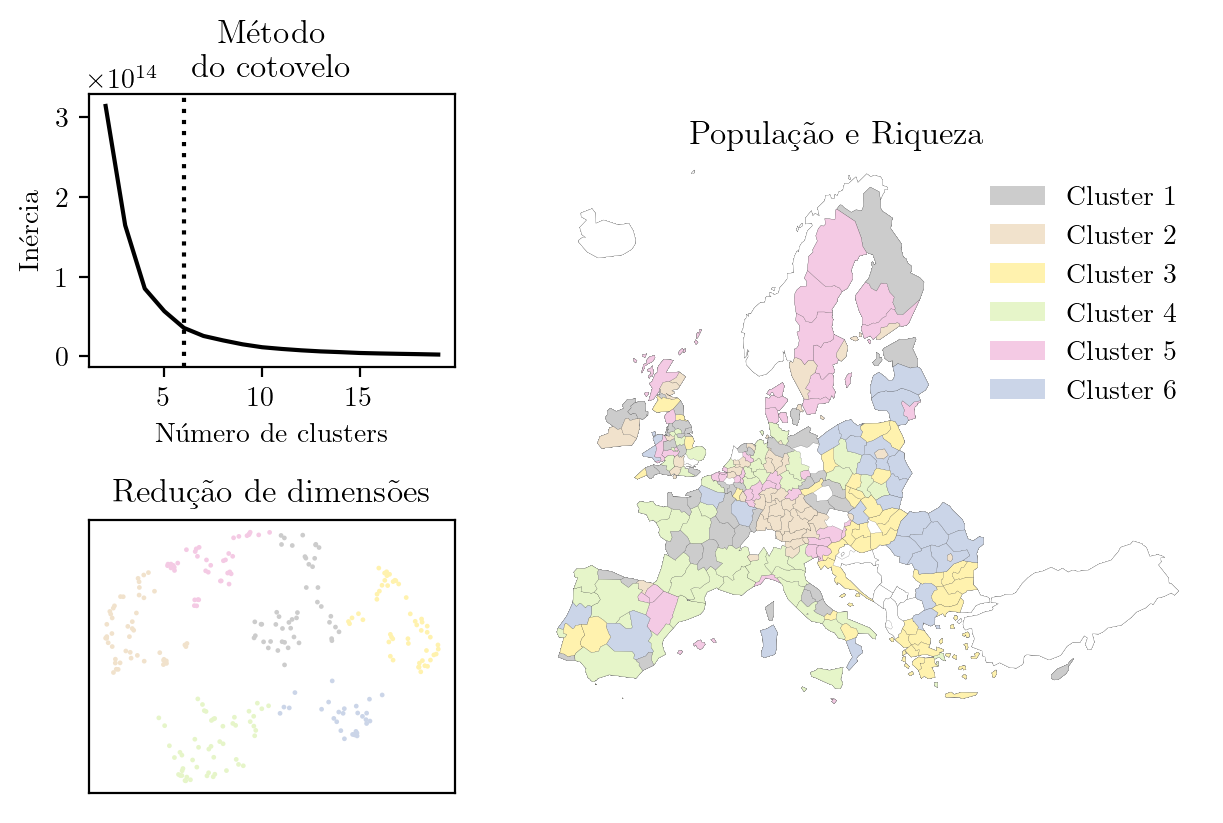

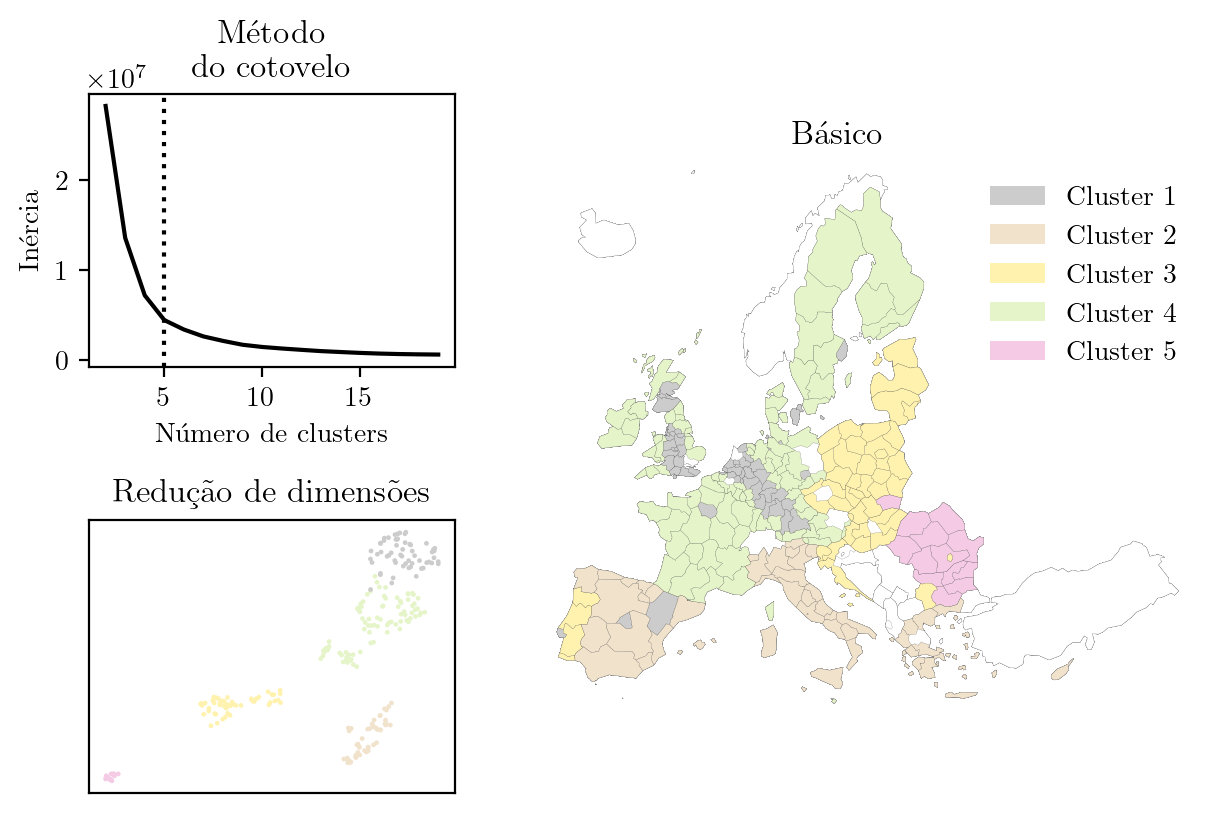

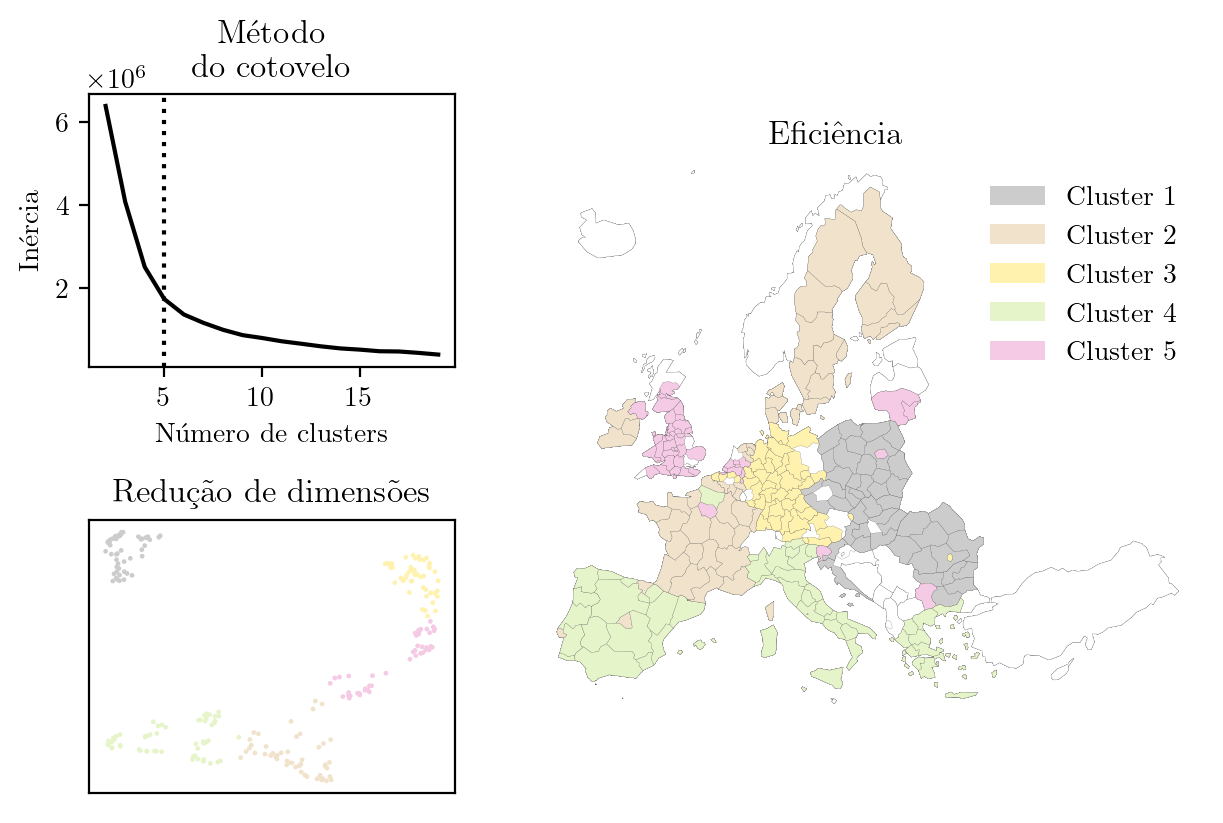

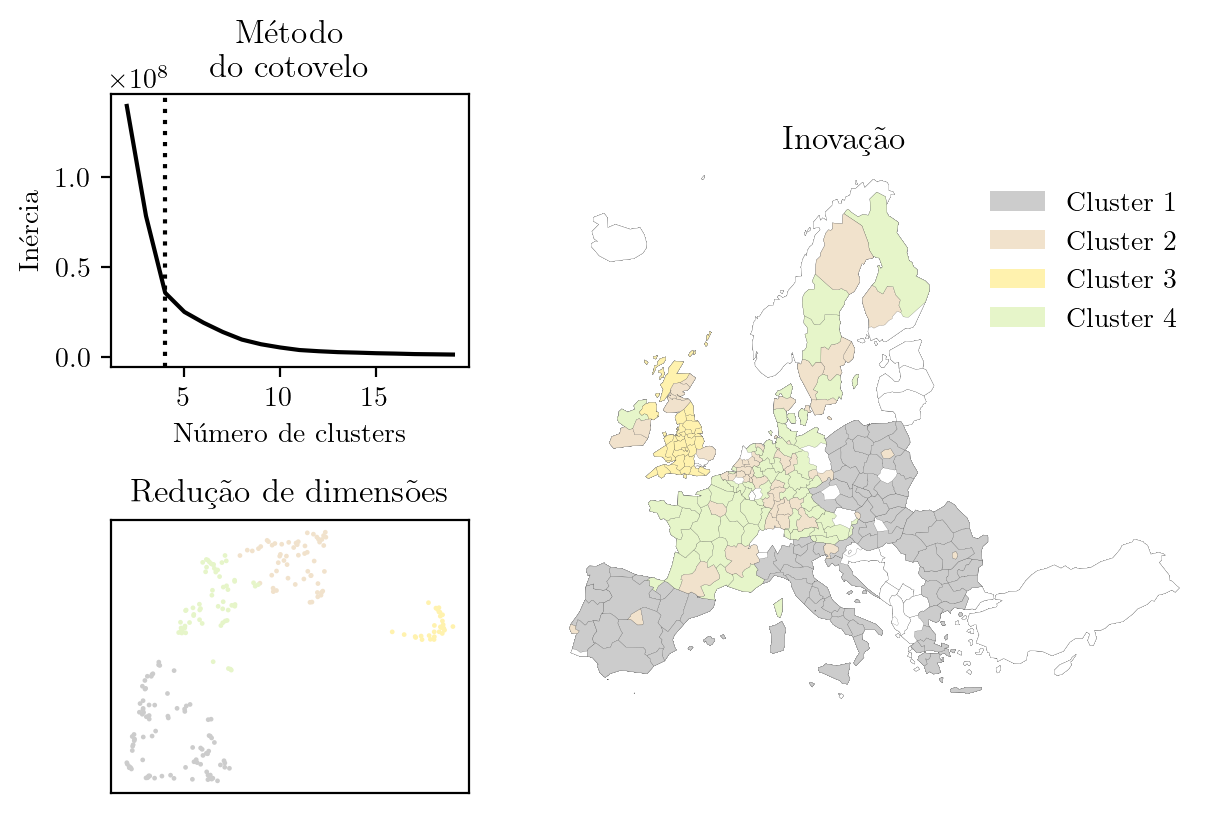

In [176]:
labels = {sheet: plotClusterEU(sheet, data[sheet], inertia[sheet], info[sheet]['n'], info[sheet]['title'], 'Pastel2_r') for sheet in sheets}

<br>

## Classification

In [322]:
selection = addLabel(data['innovation'], labels['innovation'])
X, y = selection.drop('label', axis=1).sort_index(axis=1), selection.label
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state=seed)
gs = findParameters(X_train, y_train, seed)

In [323]:
gs.best_estimator_

Pipeline(steps=[('scaler', StandardScaler()),
                ('over',
                 RandomOverSampler(random_state=100, sampling_strategy='all')),
                ('clf',
                 LGBMClassifier(colsample_bytree=0.7, max_depth=10,
                                min_split_gain=0.4, n_estimators=150,
                                num_leaves=200, random_state=100, reg_alpha=0.1,
                                reg_lambda=1.3, subsample=0.7,
                                subsample_freq=20))])

  \begin{tabular}{lrrrr}
  \toprule
  {} &  precision &    recall &  f1-score &    support \\
  \midrule
  Cluster 1    &   0.956522 &  1.000000 &  0.977778 &  22.000000 \\
  Cluster 2    &   0.823529 &  0.875000 &  0.848485 &  16.000000 \\
  Cluster 3    &   1.000000 &  0.857143 &  0.923077 &   7.000000 \\
  Cluster 4    &   0.928571 &  0.866667 &  0.896552 &  15.000000 \\
  accuracy     &   0.916667 &  0.916667 &  0.916667 &   0.916667 \\
  macro avg    &   0.927156 &  0.899702 &  0.911473 &  60.000000 \\
  weighted avg &   0.919142 &  0.916667 &  0.916611 &  60.000000 \\
  \bottomrule
  \end{tabular}


##########
# treino #
##########

input	(180, 15)
0    70
3    46
1    41
2    23
Name: label, dtype: int64

over	(280, 15)
1    70
3    70
0    70
2    70
Name: label, dtype: int64

parâmetros
{'clf': LGBMClassifier(colsample_bytree=0.7, max_depth=10, min_split_gain=0.4,
               n_estimators=150, num_leaves=200, random_state=100,
               reg_alpha=0.1, reg_lambda=1.3, subsample=0.7, subsample_freq=20),
 'clf__class_weight': None,
 'clf__colsample_bytree': 0.7,
 'clf__max_depth': 10,
 'clf__min_split_gain': 0.4,
 'clf__n_estimators': 150,
 'clf__num_leaves': 200,
 'clf__reg_alpha': 0.1,
 'clf__reg_lambda': 1.3,
 'clf__subsample': 0.7,
 'clf__subsample_freq': 20,
 'over': RandomOverSampler(random_state=100, sampling_strategy='all'),
 'over__sampling_strategy': 'all'}

matrix

              precision    recall  f1-score  support
Cluster 1      0.913043  0.954545  0.933333     22.0
Cluster 2      0.823529  0.875000  0.848485     16.0
Cluster 3      1.000000  0.857143  0.923

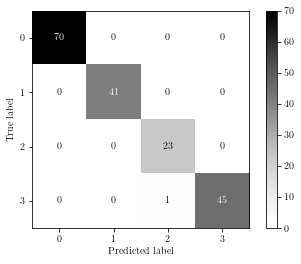


test


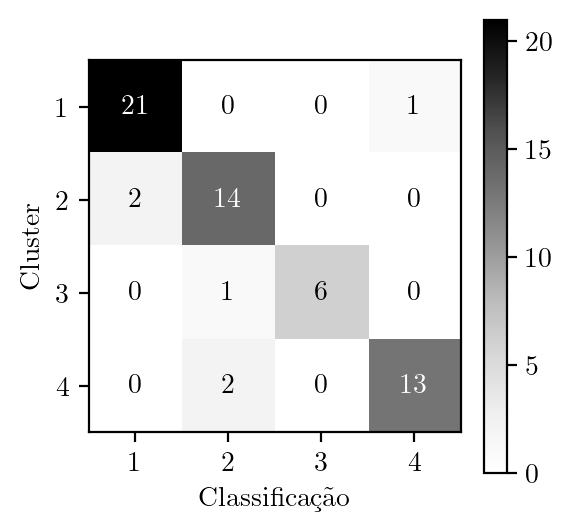

In [351]:
printReport(gs, [X_train, y_train], [X_test, y_test])

<br>

## Analysis

In [325]:
classes = [f"Cluster {x+1}" for x in range(len(y.unique()))]

In [326]:
X_shap = pd.DataFrame(gs.best_estimator_.named_steps['scaler'].transform(X), index=X.index, columns=X.columns)

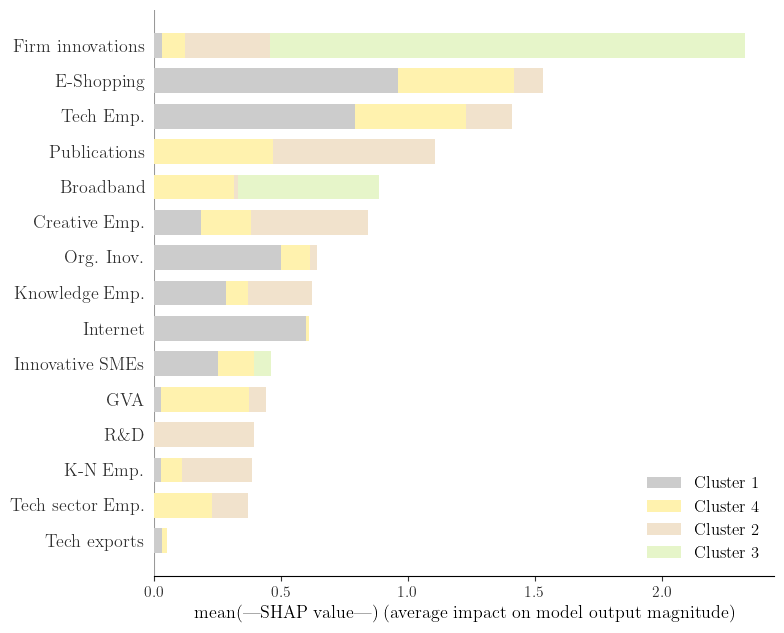

In [327]:
f = plt.figure(figsize=(5,5), dpi=100)
explainer = shap.TreeExplainer(gs.best_estimator_.named_steps['clf'])
shap_values = explainer.shap_values(X_shap)
shap.summary_plot(shap_values, prepareLaTeX(X_shap), plot_type="bar", color=mpl.colors.ListedColormap([plt.cm.Pastel2_r(i) for i in [0,2,1,3]]), class_names=classes)
f.savefig("graphs/features.pdf", bbox_inches='tight')
plt.show()

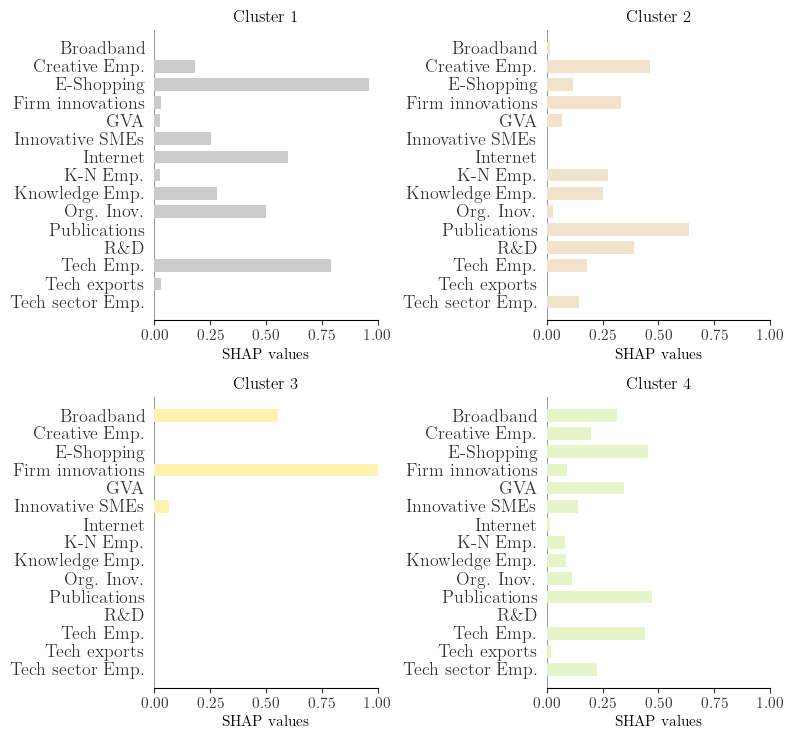

In [328]:
fig = plt.figure(figsize=(5,5), dpi=100)

for i, x in enumerate(classes):
    ax2 = fig.add_subplot(220+(i+1))
    ax2.title.set_text(x)
    shap.summary_plot(shap_values[i], prepareLaTeX(X_shap), plot_type="bar", color=plt.cm.Pastel2_r(i), show=False, sort=False)
    plt.xlim(0,1)
    ax2.set_xlabel(r'SHAP values', fontsize=11)

# plt.tight_layout(pad=3) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.tight_layout()
fig.savefig("graphs/classes.pdf", bbox_inches='tight')
plt.show()

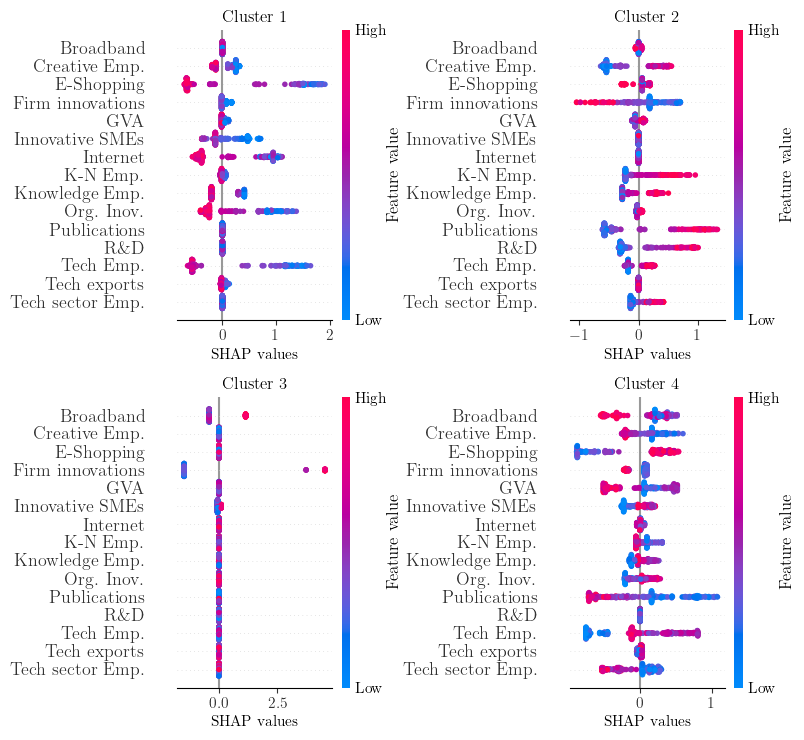

In [329]:
fig = plt.figure(figsize=(5,5), dpi=100)
for i, x in enumerate(classes):
    ax2 = fig.add_subplot(220+(i+1))
    ax2.title.set_text(x)
    shap.summary_plot(shap_values[i], prepareLaTeX(X_shap), show=False, sort=False)#,  cmap=plt.get_cmap('Greys'), )
    # plt.xlim(-2,2)
    ax2.set_xlabel(r'SHAP values', fontsize=11)
# plt.tight_layout(pad=3) # You can also use plt.tight_layout() instead of using plt.subplots_adjust() to add space between plots
plt.tight_layout()
fig.savefig("graphs/distribution.pdf", bbox_inches='tight')
plt.show()